# Data Set-

Kaggle - https://www.kaggle.com/datasets/msambare/fer2013
The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)


# Importing the dataset from kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d msambare/fer2013 --force


 81% 49.0M/60.3M [00:00<00:00, 156MB/s]
100% 60.3M/60.3M [00:00<00:00, 153MB/s]


In [ ]:
!unzip /content/fer2013.zip -d /content/


Streaming output truncated to the last 5000 lines.
  inflating: /content/train/sad/Training_65242339.jpg  
  inflating: /content/train/sad/Training_65267116.jpg  
  inflating: /content/train/sad/Training_65275626.jpg  
  inflating: /content/train/sad/Training_6529266.jpg  
  inflating: /content/train/sad/Training_65329617.jpg  
  inflating: /content/train/sad/Training_65338712.jpg  
  inflating: /content/train/sad/Training_65338797.jpg  
  inflating: /content/train/sad/Training_65387162.jpg  
  inflating: /content/train/sad/Training_65404494.jpg  
  inflating: /content/train/sad/Training_65426218.jpg  
  inflating: /content/train/sad/Training_65430136.jpg  
  inflating: /content/train/sad/Training_65437377.jpg  
  inflating: /content/train/sad/Training_6545735.jpg  
  inflating: /content/train/sad/Training_65463385.jpg  
  inflating: /content/train/sad/Training_65473985.jpg  
  inflating: /content/train/sad/Training_65502829.jpg  
  inflating: /content/train/sad/Training_65505359.jpg  

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model

# Setting up Directory to save various model.

In [ ]:
project_name = 'Emotion_Detection_Model'

base_dir = '/content/'

model_name = ['Model_from_Scratch', 'Model_with_Data_Augmentation', 'Model_with_VGG16', 'Model_with_ResNet50']

project_dir = os.path.join(base_dir, project_name)
os.makedirs(project_dir, exist_ok=True)

for model in model_name:
  model_dir = os.path.join(project_dir, model)
  os.makedirs(model_dir, exist_ok=True)

# **Data Cleaning**

## Check all the files extensions in image format or not

In [ ]:
def check_file_extension(name_of_directory):
  file_extension = ['.jpeg', '.png', '.jpg']
  emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
  for emotion in emotions:
    emotion_directory = os.path.join(name_of_directory, emotion)
    for filename in os.listdir(emotion_directory):
      _, extension = os.path.splitext(filename)
      if extension not in file_extension:
        print(filename)

In [ ]:
check_file_extension(name_of_directory='/content/train/')

In [ ]:
check_file_extension(name_of_directory='/content/test/')

# **Data Analysis**

# Counting no of img files from each each category/directory

In [ ]:
def image_count(directory_name):
    emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
    file_count = dict()
    for emotion in emotions:
        single_directory = os.path.join(directory_name, emotion)
        imgs_file_paths = os.listdir(single_directory)
        total_images = len(imgs_file_paths)
        file_count[emotion] = total_images
    return file_count

In [ ]:
count_images = image_count(directory_name='/content/train')
count_images

{'angry': 3995,
 'disgust': 436,
 'fear': 4097,
 'happy': 7215,
 'neutral': 4965,
 'sad': 4830,
 'surprise': 3171}

In [ ]:
def counting_no_of_images(directory_):
    emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
    file_count = dict()
    for emotion in emotions:
        single_directory = os.path.join(directory_, emotion)
        imgs_file_paths = os.listdir(single_directory)
        total_images = len(imgs_file_paths)
        file_count[emotion] = total_images

    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.pie(file_count.values(), labels=file_count.keys(), autopct='%1.1f%%', startangle=140)
    plt.title('Distribution of Images in Each Category')
    plt.axis('equal')

    plt.subplot(1, 2, 2)
    bars = plt.bar(file_count.keys(), file_count.values(), color='skyblue')
    plt.xlabel('Emotion')
    plt.ylabel('Number of Images')
    plt.title('Number of Images in Each Category')
    plt.xticks(rotation=45)

    # Adding text annotations to each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom')

    plt.tight_layout()
    plt.show()



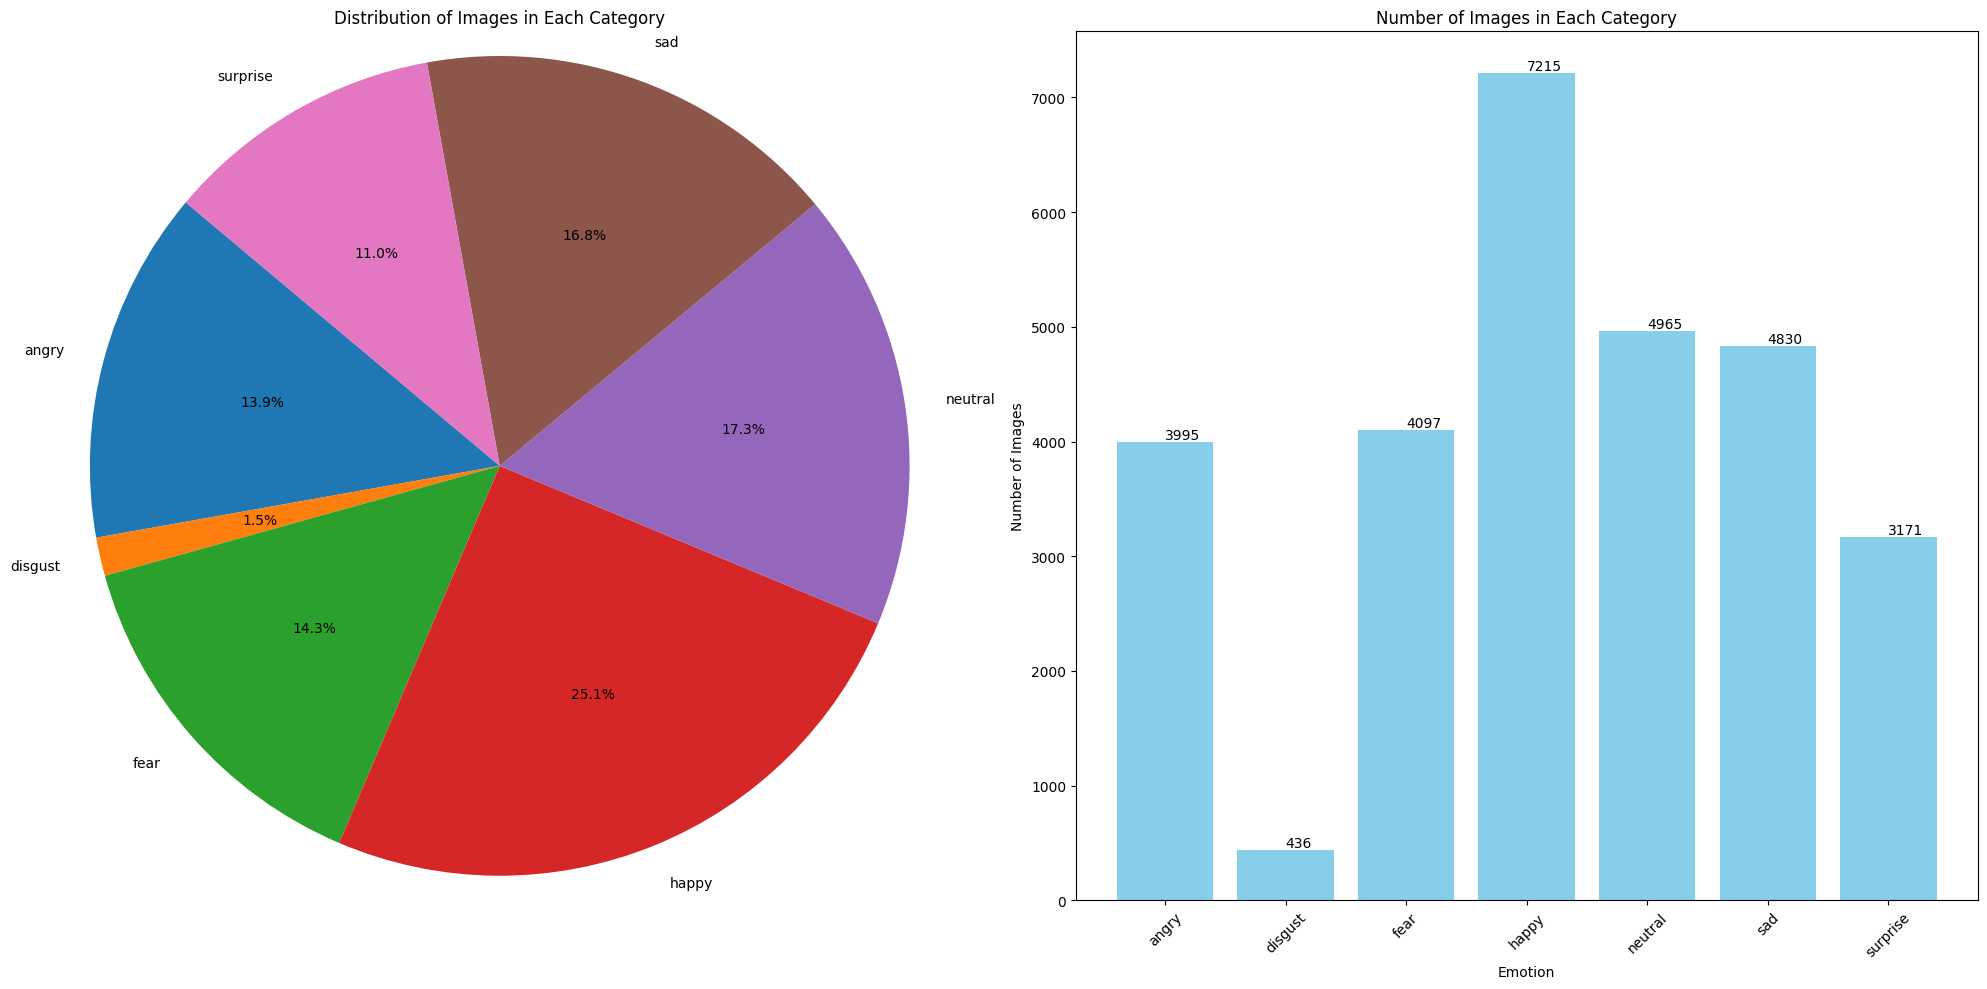

In [ ]:
counting_no_of_images(directory_='/content/train')

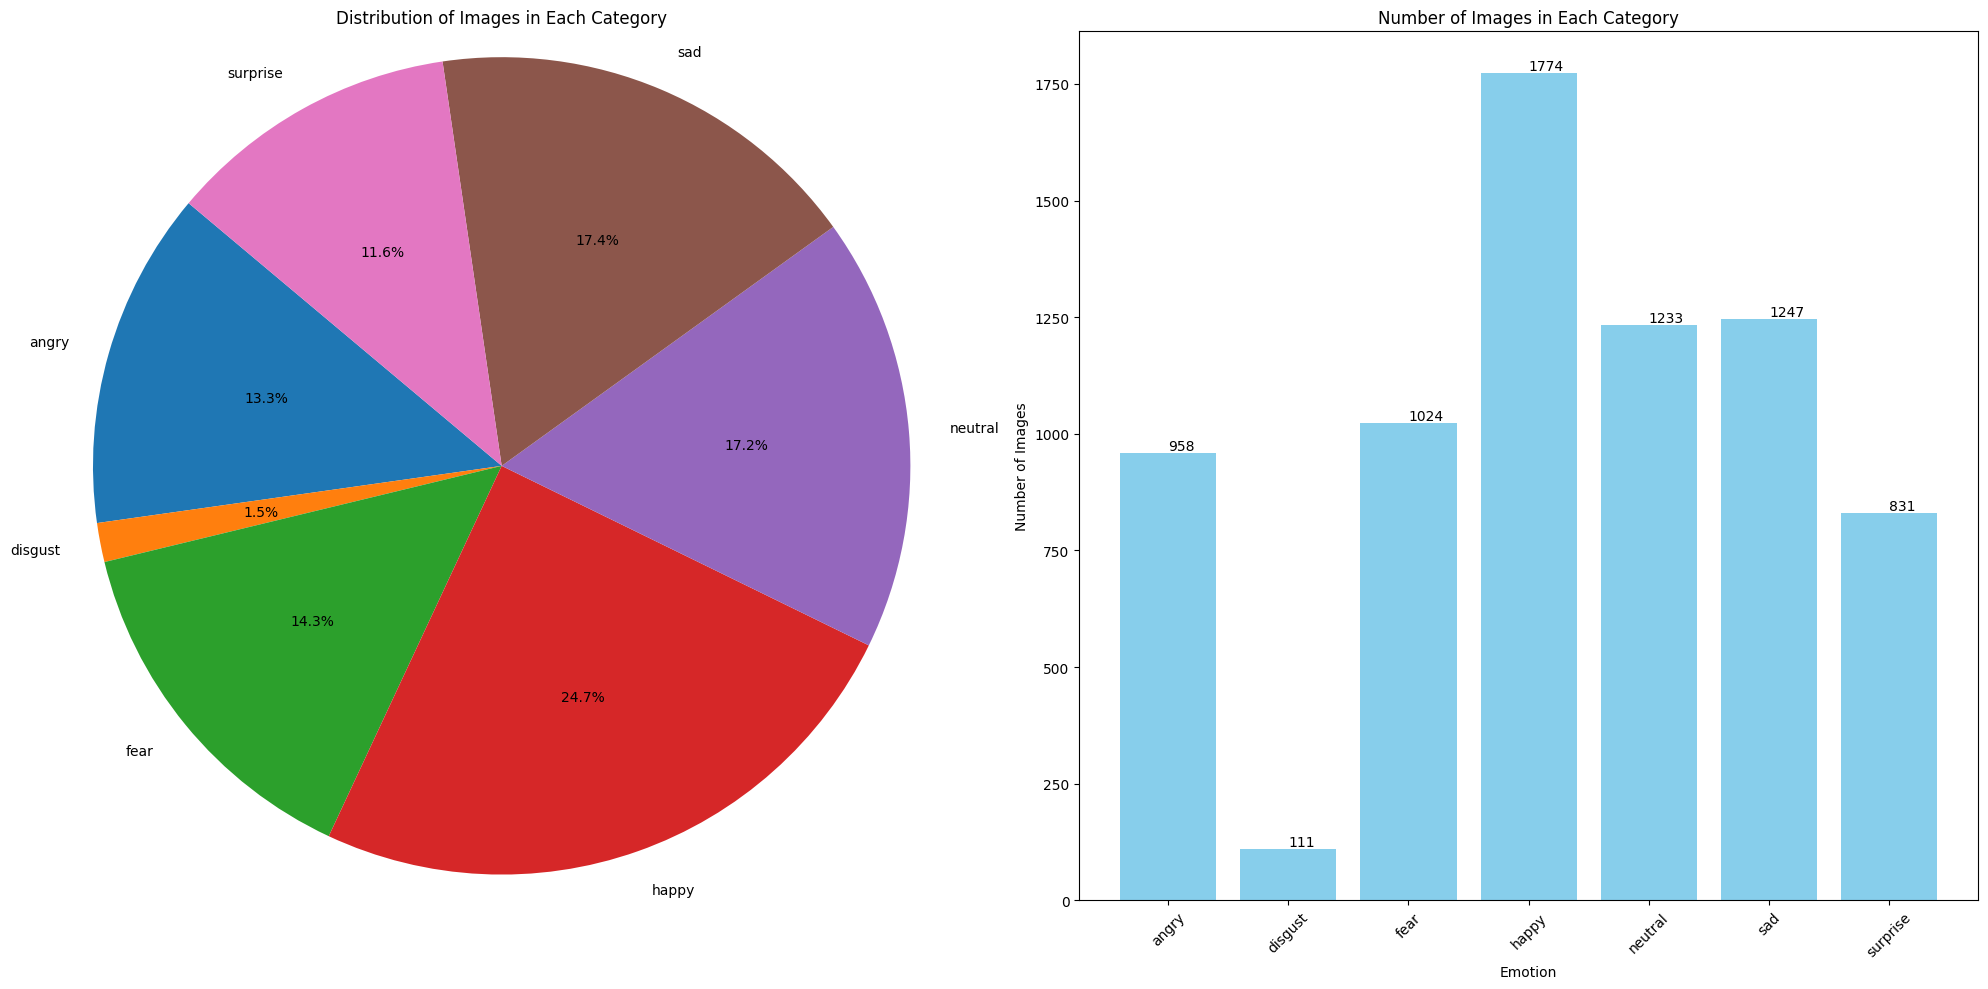

In [ ]:
counting_no_of_images(directory_='/content/test')

# **In both train and test datasets, the images are highly imbalanced w.r.t different classes.**

### During training the model, we need to look carefully to all the metrics in order to build a good emotion detection model




# Plotting one random image from each directory and checking image size

In [ ]:
def plotting_random(directory_path):
  emotions = os.listdir(directory_path)
  plt.figure(figsize=(15,10))

  for i, emotion in enumerate(emotions):
    folder = os.path.join(directory_path, emotion)
    img_files = os.listdir(folder)
    random_img_file = random.choice(img_files)
    img_path = os.path.join(folder, random_img_file)
    img = plt.imread(img_path)
    plt.subplot(3, 4, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"{emotion} -> img_size - {img.shape}")
    plt.axis('off')



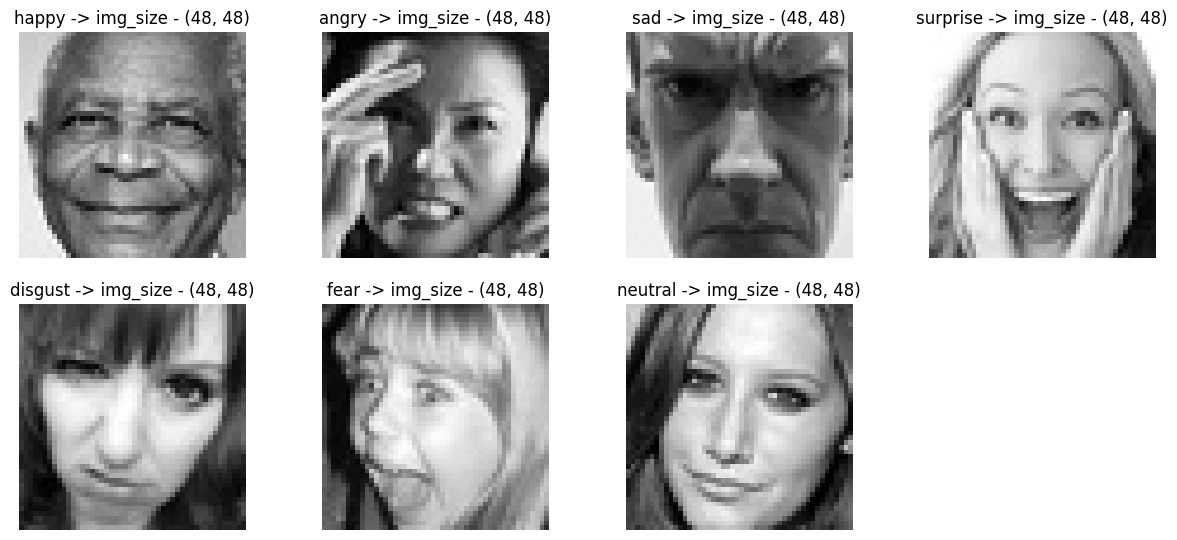

In [ ]:
plotting_random(directory_path='/content/train')

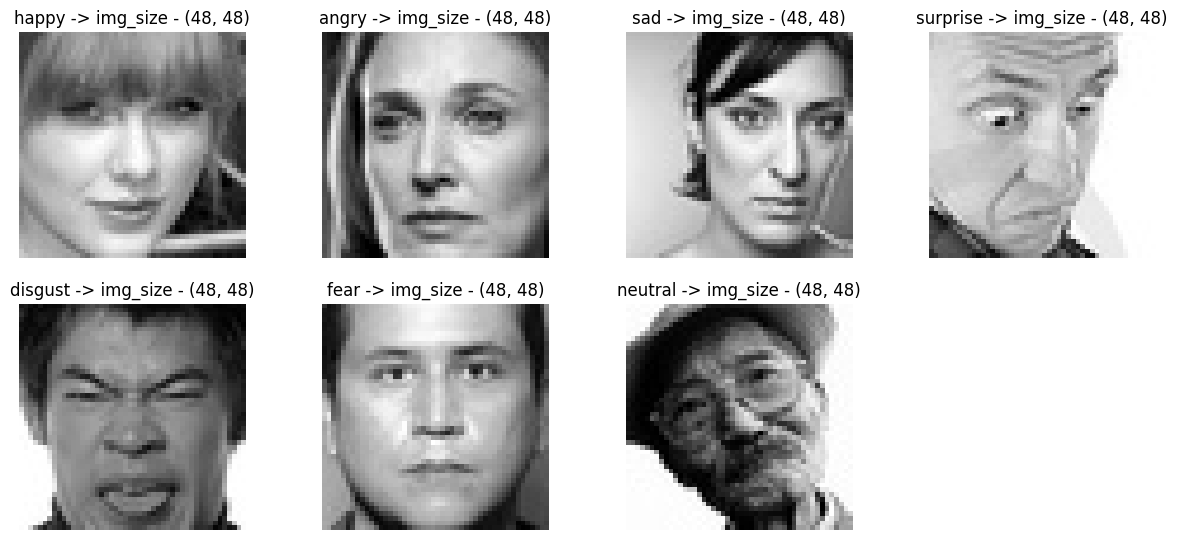

In [ ]:
plotting_random(directory_path='/content/test')

### All the images are of same shape (48,48,1)

# **Plotting randomly 9 number of images from each category/directory**

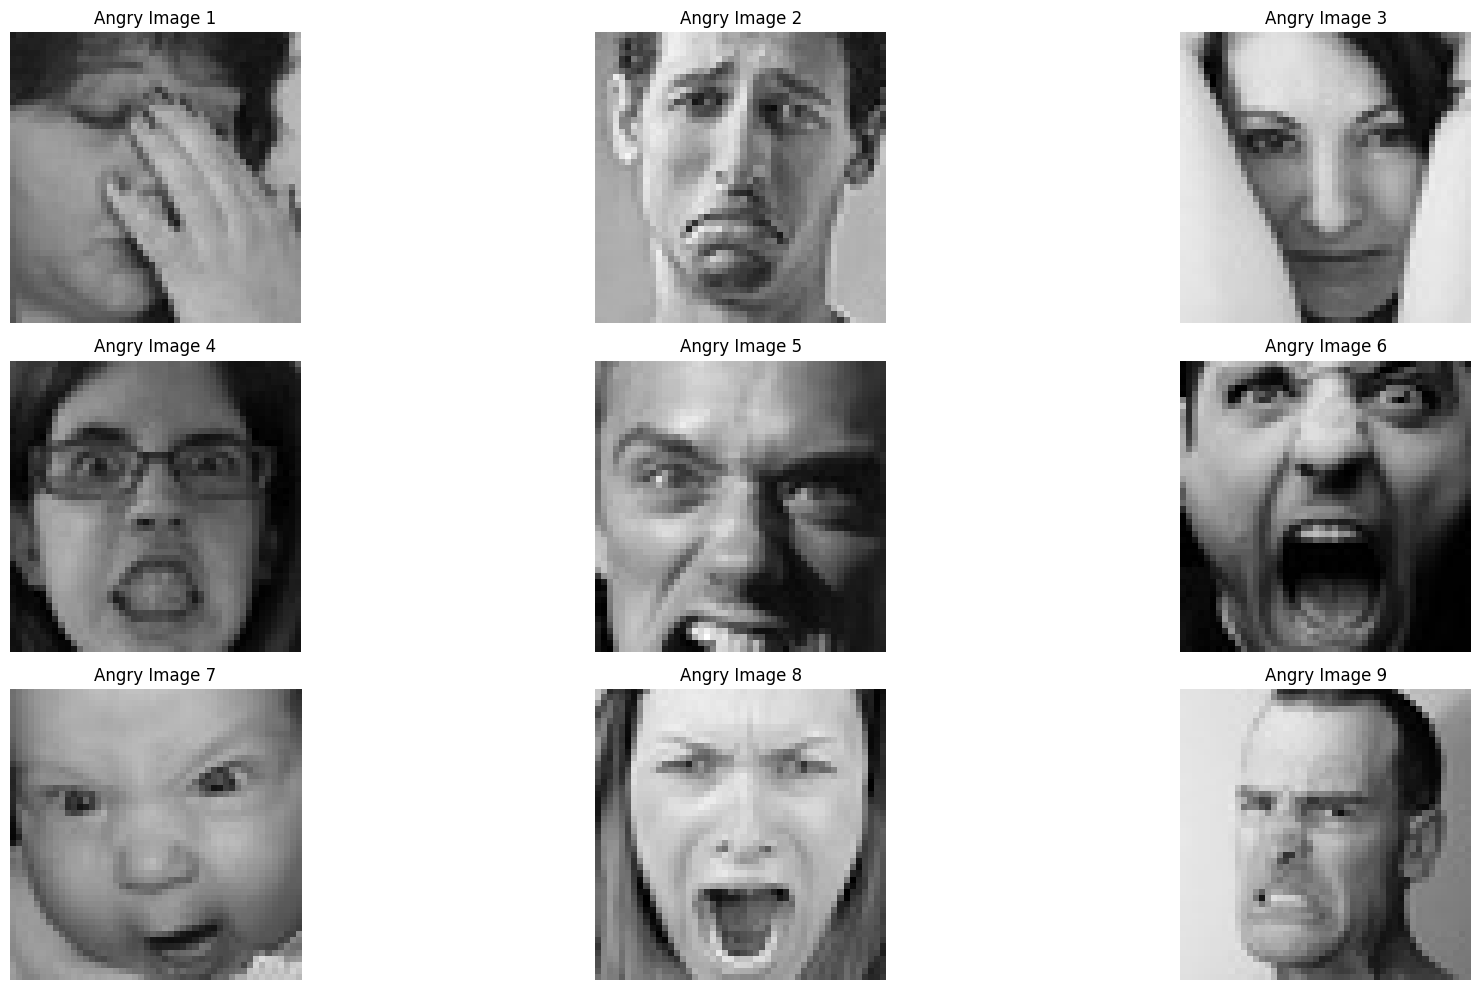

In [ ]:
def plotting_images(directory_name, set_name, no_of_images=9):
    fig, axes = plt.subplots(3, 3, figsize=(20, 10))
    axes = axes.ravel()

    # Get the list of image files in the directory
    img_files = os.listdir(directory_name)
    num_files = len(img_files)

    # Loop through the desired number of images
    for i in range(no_of_images):
        # Generate a random index from the range of available files
        random_num = random.randint(0, num_files - 1)

        # Get the image file name and path
        img_file_name = img_files[random_num]
        img_path = os.path.join(directory_name, img_file_name)

        img = cv2.imread(img_path)

        # Plot the image
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"{set_name} Image {i + 1}")

    plt.tight_layout()
    plt.show()


plotting_images(directory_name='/content/train/angry/', set_name='Angry', no_of_images=9)


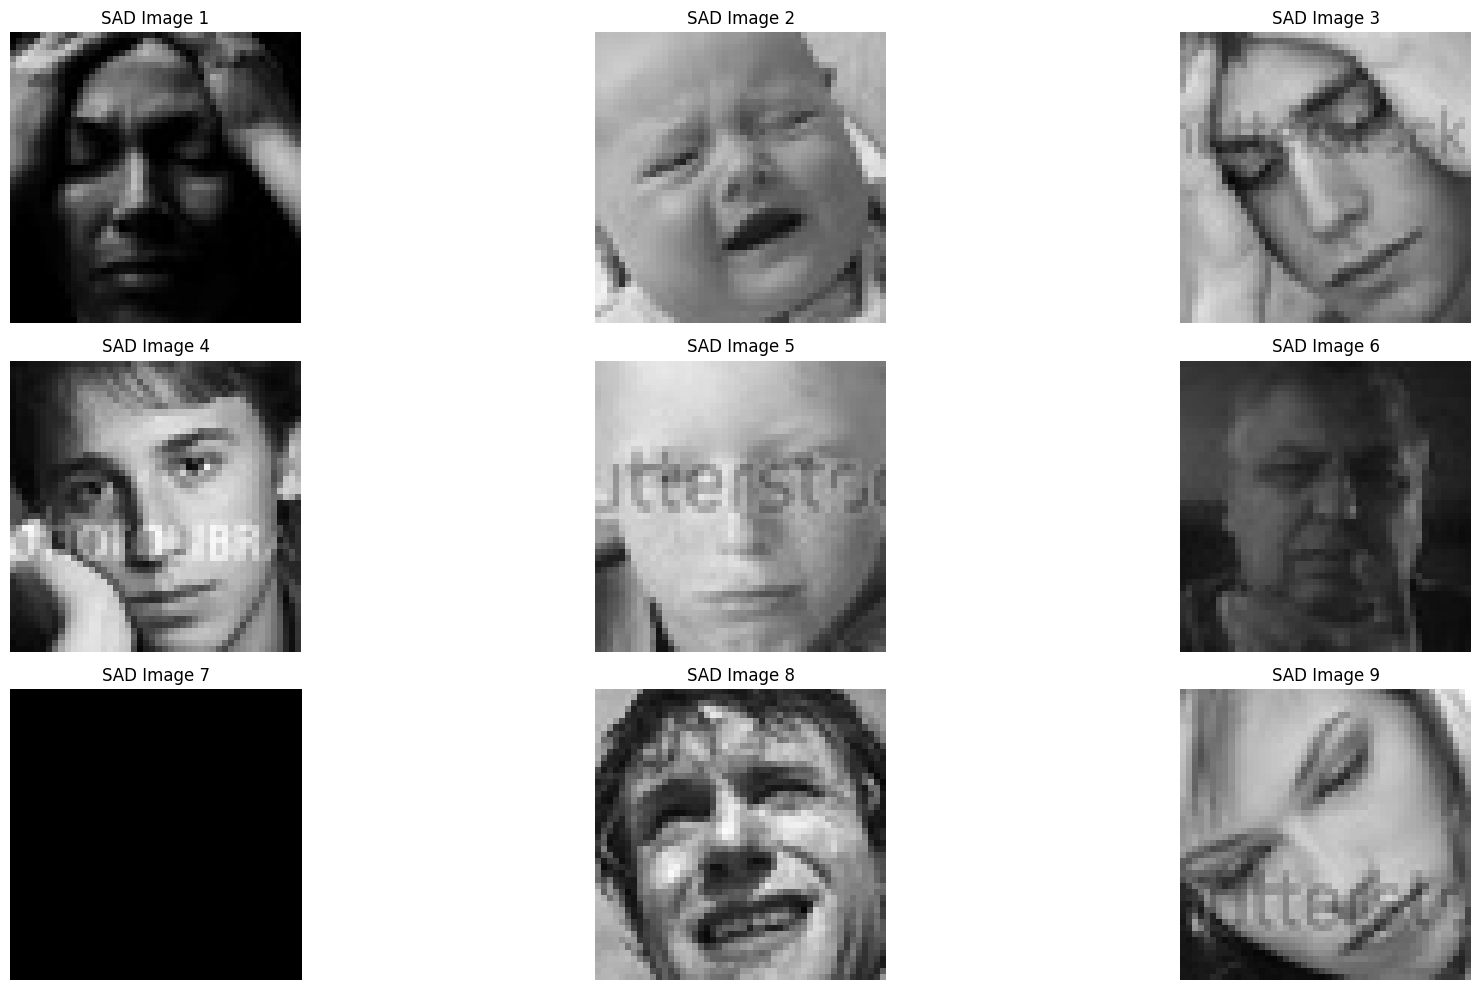

In [ ]:
plotting_images(directory_name='/content/train/sad/', set_name = 'SAD', no_of_images=9)

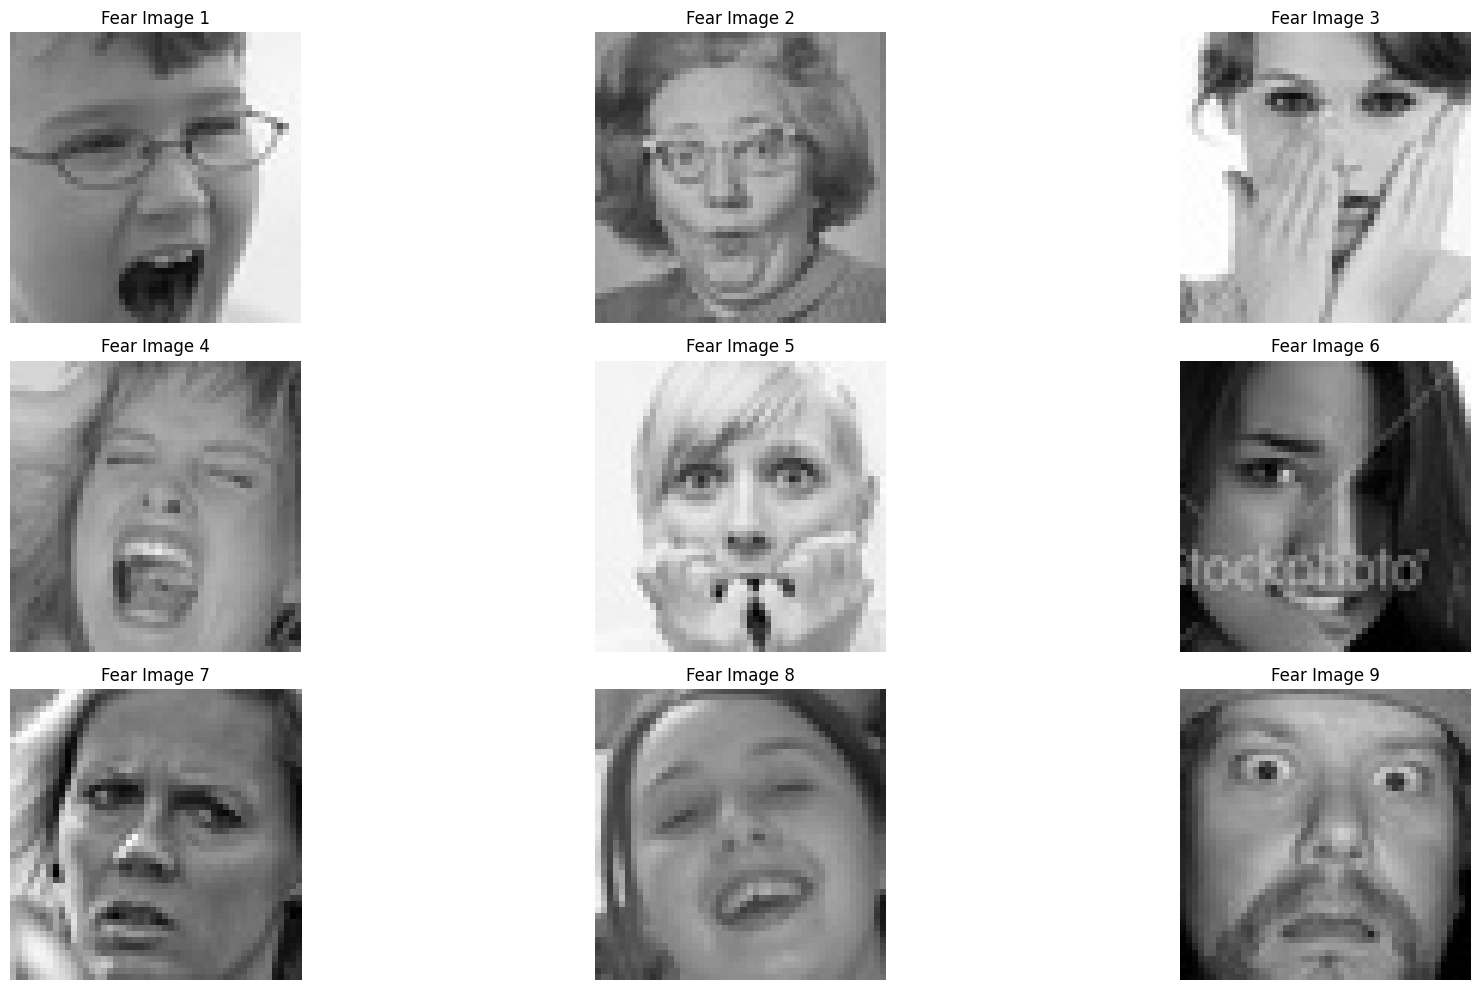

In [ ]:
plotting_images(directory_name='/content/train/fear/', set_name = 'Fear', no_of_images=9)

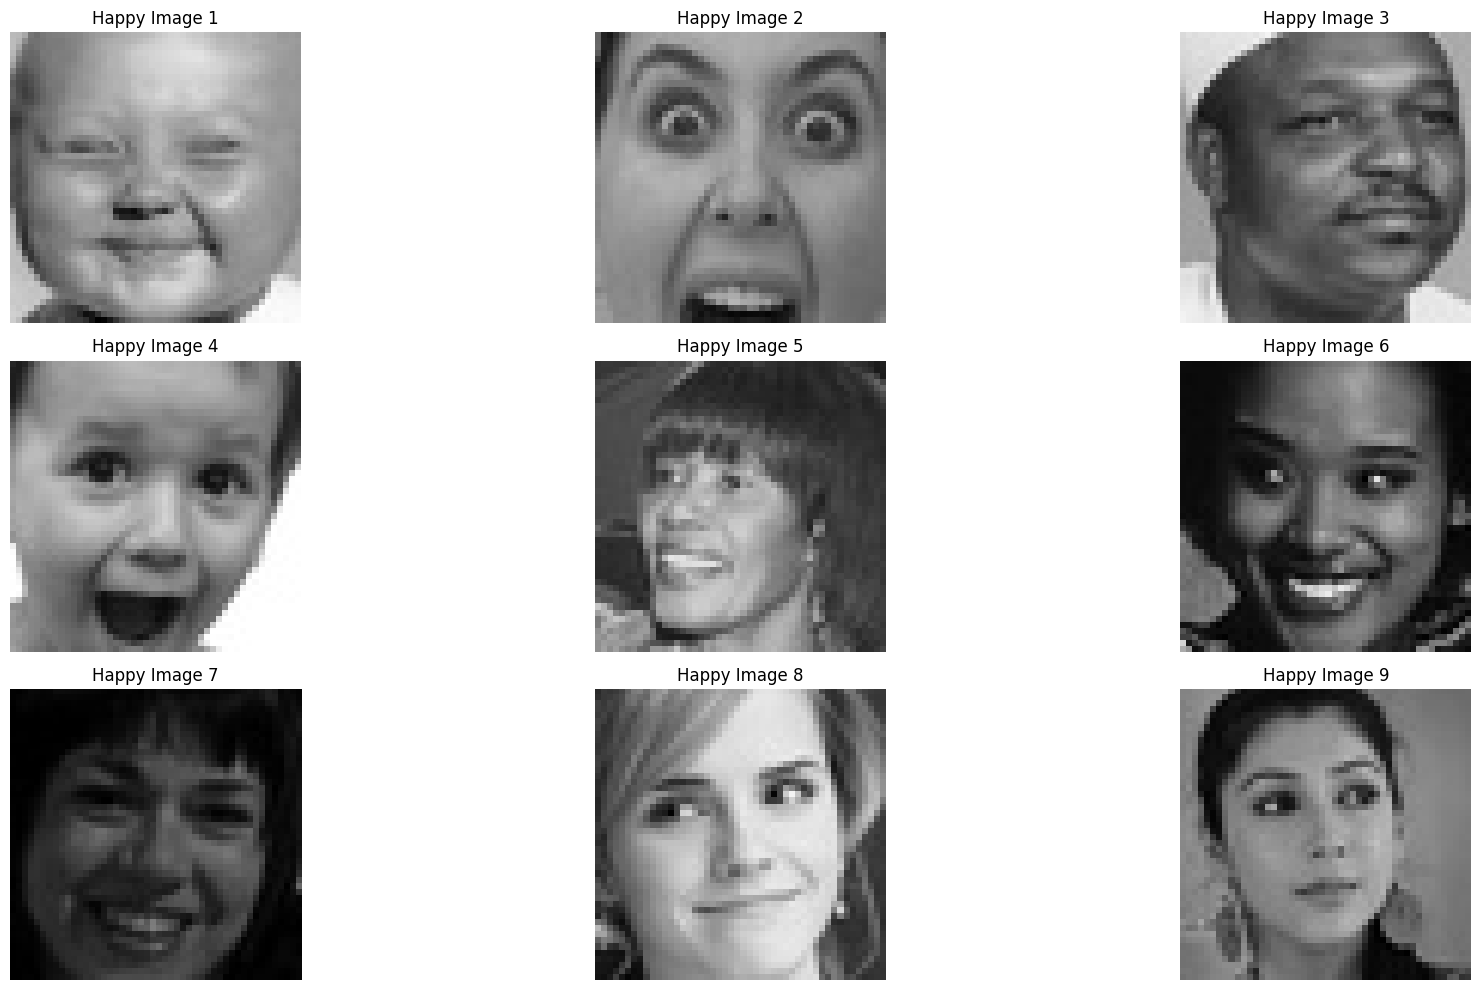

In [ ]:
plotting_images(directory_name='/content/train/happy/', set_name = 'Happy', no_of_images=9)

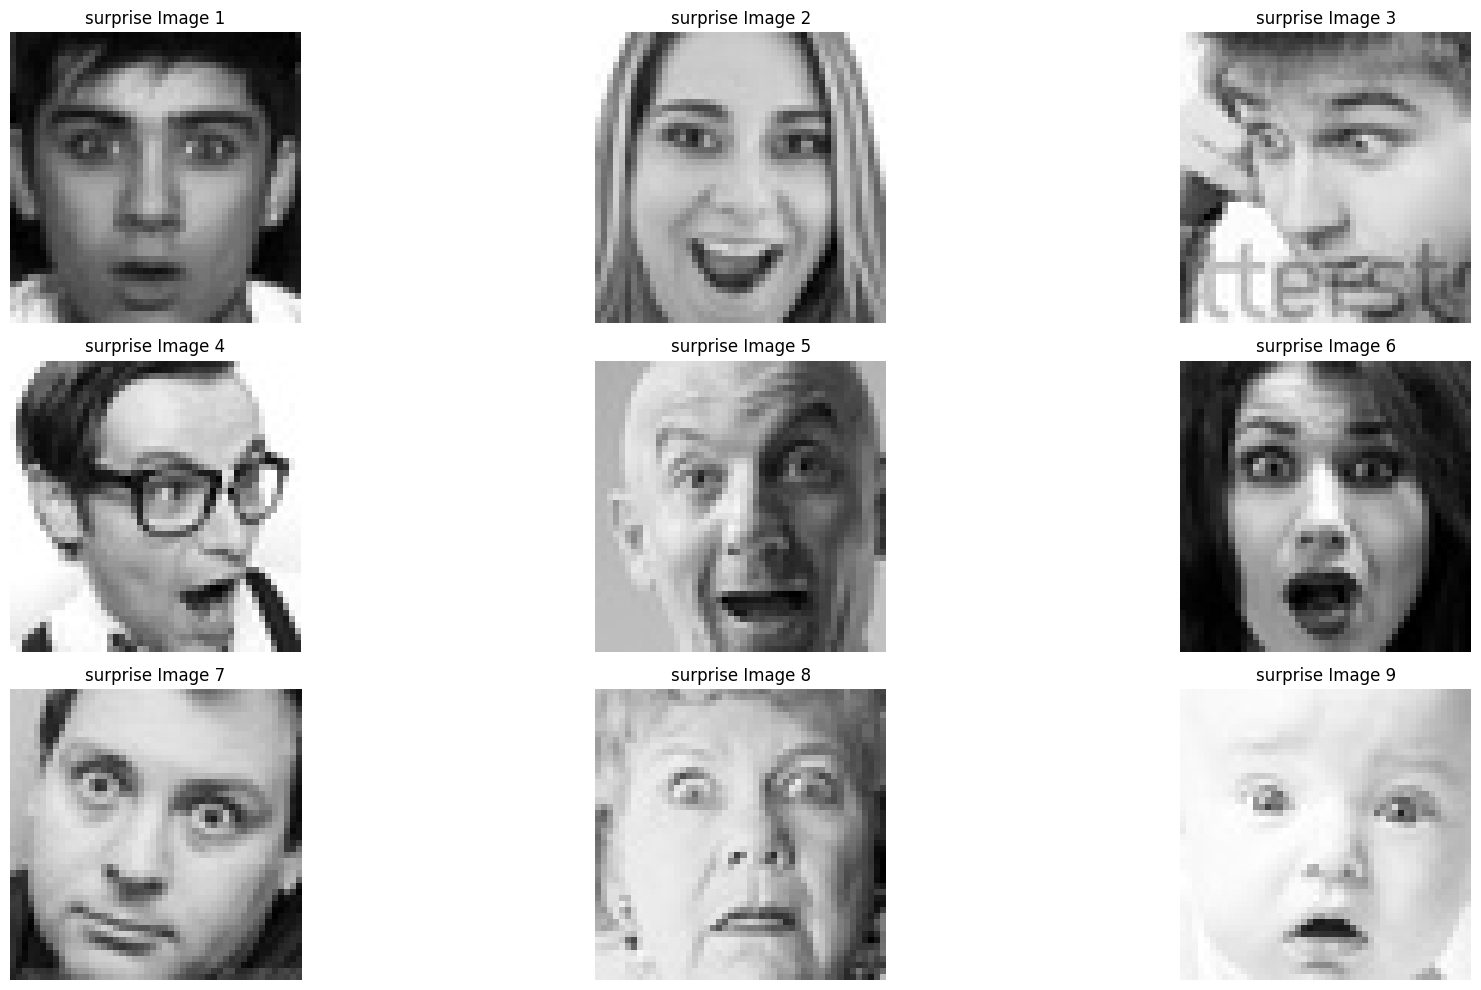

In [ ]:
plotting_images(directory_name='/content/train/surprise', set_name = 'surprise', no_of_images=9)

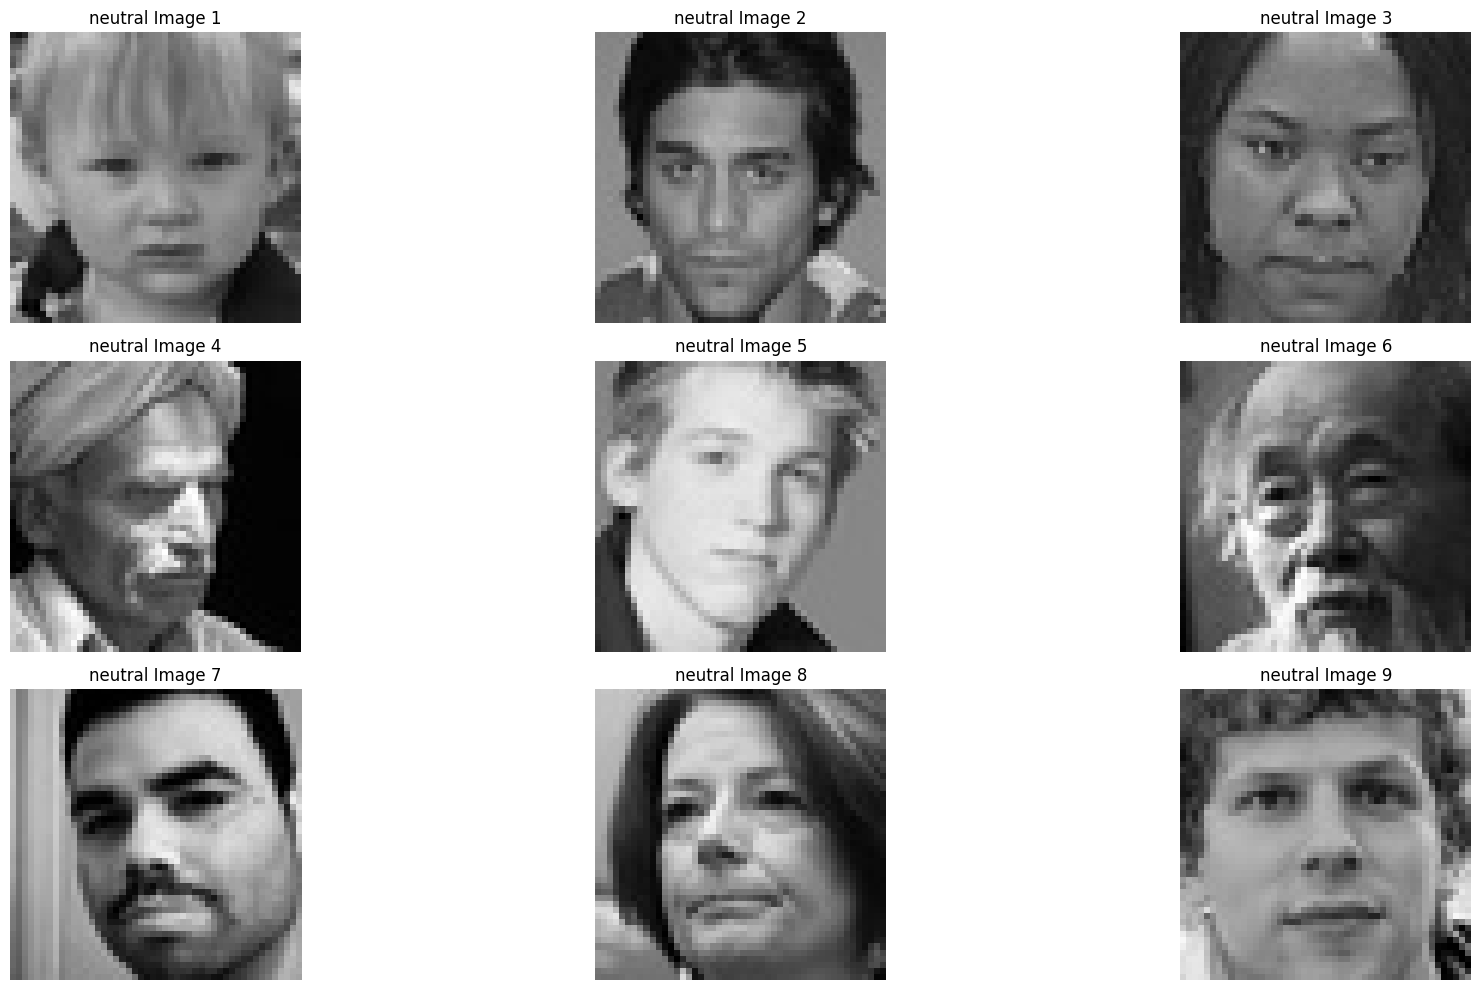

In [ ]:
plotting_images(directory_name='/content/train/neutral/', set_name = 'neutral', no_of_images=9)

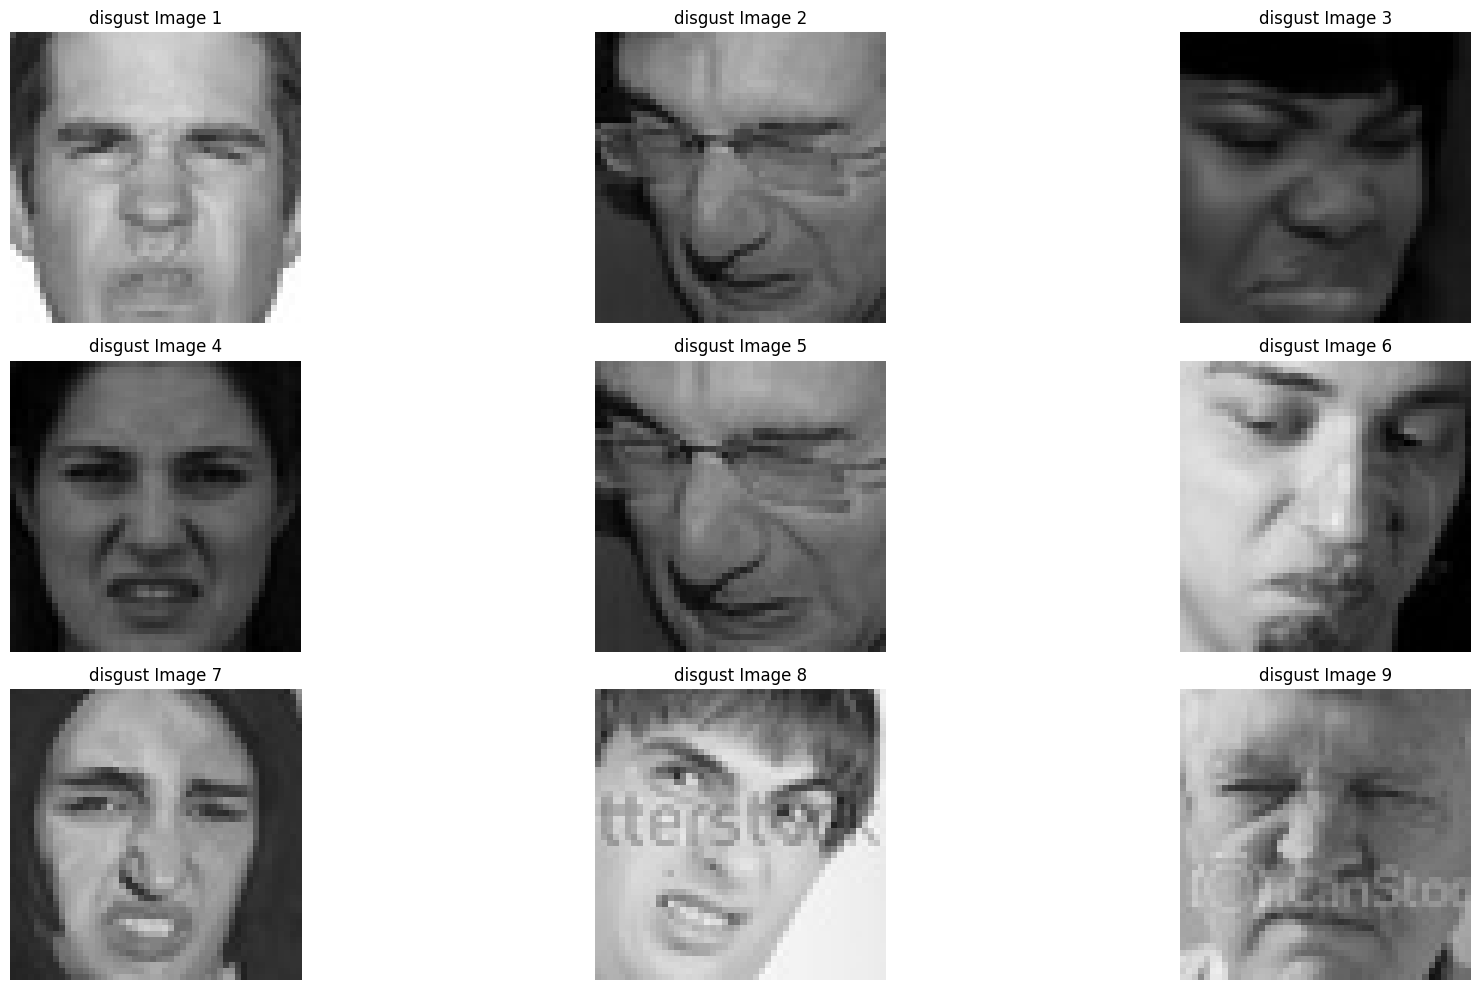

In [ ]:
plotting_images(directory_name='/content/train/disgust/', set_name = 'disgust', no_of_images = 9 )

### Data Cleaning and Visualization is done. Now lets build different models.

#### MOdels:
1. CNN Model from Scratch 
2. CNN Model with Image Augmentation
3. CNN Model with Transfer Learning (VGG16)
4. CNN Model with Transfer Learning (ResNet50)